Выделим следующие риск-факторы:
* процентные ставки **IR RUB** (процентный риск)
* курсы валют **USD, CHF** (валютный риск)
* цены товаров **BRENT** и драгоценных металлов **GOLD** (товарный риск)
* котировки акций **IMOEX, RTSI** (фондовый риск)

В качестве модели динамики будем использовать модель *Геометрического броуновского движения (GBM)*, которая позволяет моделировать динамику цен на финансовом рынке.

${S_{t}=S_{0}\exp \left(\left(\mu -{\frac {\sigma ^{2}}{2}}\right)t+\sigma W_{t}\right),}$

где $W_{t}$ - винеровский процесс, $\mu$ и $\sigma$ - параметры моделируемого риск-фактора, $S_{0}$ - начальное состояние риск-фактора.

Приращения случайного процесса вычисляются по следущей формуле:
${dS_{t}=\mu S_{t}\,dt+\sigma S_{t}\,dW_{t}}$

При симуляции всех факторов единовременно соблюдается их скоррелированность в каждом сценарии (симуляции). Для этого реализованы симуляции скоррелированных приращений Винеровского процесса с использованием разложения Холецкого для матрицы корреляций.

In [1]:
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
# Обучение проводим включительно по эту дату
split_date = "2020-12-30"

In [3]:
interest_rates = ["cbr_g_curve"]
currencies = ["USD", "CHF"]
indexes = ["BRENT", "GOLD", "IMOEX", "RTSI"]

In [4]:
path = "./data/{}.csv"
df = []
for stock in tqdm(interest_rates + currencies + indexes):
    spath = path.format(stock)
    df.append(pd.read_csv(spath))

  0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
df_merged = df[0]
for x in df[1:]:
    df_merged = pd.merge(df_merged, x, on=["Date"], how="outer")
df_merged.set_index("Date", inplace=True)
df_merged.sort_index(inplace=True)
df_merged.dropna(inplace=True)
print(len(df_merged))

1130


In [6]:
df_merged.head(3)

,0.25,0.5,0.75,1.0,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0,USD,CHF,BRENT,GOLD,IMOEX,RTSI
Date,,,,,,,,,,,,,,,,,,
2016-01-12,0.0970,0.1033,0.1062,0.1074,0.1065,0.1054,0.1046,0.1039,0.1024,0.1014,0.1011,0.1010,75.9507,76.1869,30.860001,2697.53,1690.300049,695.32
2016-01-13,0.0967,0.1029,0.1054,0.1062,0.1056,0.1055,0.1052,0.1041,0.1024,0.1014,0.1012,0.1012,76.6041,76.7499,30.309999,2696.48,1684.780029,693.65
2016-01-14,0.0954,0.1019,0.1046,0.1055,0.1059,0.1062,0.1060,0.1050,0.1036,0.1029,0.1028,0.1030,76.4275,76.0321,31.030001,2658.20,1680.770020,692.99


In [7]:
train_df = df_merged[df_merged.index <= split_date].pct_change().dropna(axis=0)
test_df = df_merged[df_merged.index > split_date].pct_change().dropna(axis=0)
all_df = df_merged.pct_change().dropna(axis=0)

In [8]:
train_df.shape, test_df.shape

((936, 18), (192, 18))

In [8]:
def get_step_simulations(data, t, rounds=1000, random_state=42):
    """
    Симуляция процентного приращения риск-фактора на t шагов вперед
    """
    rnd = np.random.RandomState(random_state)
    corr_matrix = np.linalg.cholesky(np.corrcoef(data, rowvar=False))
    rnd_vec = (
        corr_matrix
        @ np.cumsum(np.sqrt(1 / t) * rnd.normal(loc=0, scale=1, size=(data.shape[1], rounds, t)), axis=2)[:, :, -1]
    )
    # здесь вычисляется процентное приращение риск-фактора
    new_vals = np.exp((data.mean(axis=0) - data.std(axis=0) ** 2 / 2) / t + data.std(axis=0) * rnd_vec.T) - 1
    return new_vals.T

In [9]:
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(train_df)
df_pca = pca.transform(all_df)

Симуляция на 1 день с окном для расчета среднего и стд. отклонения в 30 дней

In [10]:
window_size = 30
t = 1
simulations = []
for i in tqdm(range(len(df_pca) - window_size - t)):
    x = get_step_simulations(df_pca[i : i + window_size], t)
    simulations.append(-np.percentile(x, 1, axis=1))
simulations = np.array(simulations)
simulations.shape

  0%|          | 0/1098 [00:00<?, ?it/s]

(1098, 3)

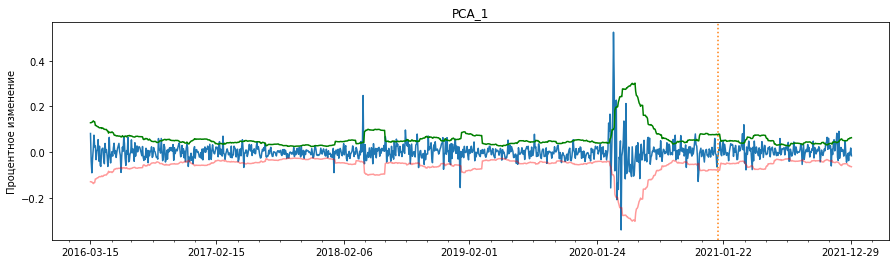

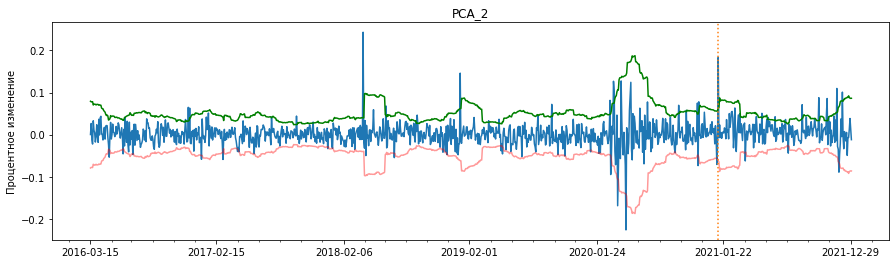

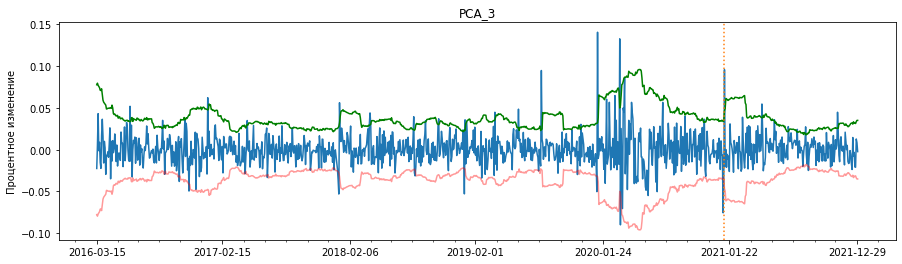

In [11]:
for i in range(df_pca.shape[1]):
    plt.figure(figsize=(15, 4))
    idx = all_df.index[window_size + t :]
    plt.plot(idx, df_pca[window_size + t :, i])
    plt.plot(idx, simulations[:, i], c="g")
    plt.plot(idx, -simulations[:, i], c="r", alpha=0.4)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.axvline(split_date, c="tab:orange", linestyle=":")
    plt.title(f"PCA_{i+1}")
    plt.ylabel("Процентное изменение")
    plt.show()

Симуляция на 10 дней с окном для расчета среднего и стд. отклонения в 30 дней

In [12]:
window_size = 30
t = 10
simulations = []
for i in tqdm(range(len(df_pca) - window_size - t)):
    x = get_step_simulations(df_pca[i : i + window_size], t)
    simulations.append(-np.percentile(x, 1, axis=1))
simulations = np.array(simulations)
simulations.shape

  0%|          | 0/1089 [00:00<?, ?it/s]

(1089, 3)

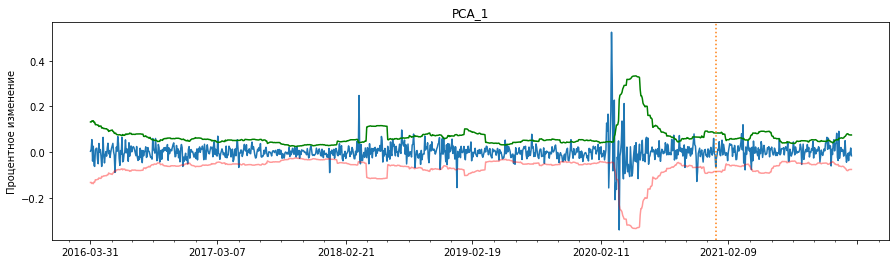

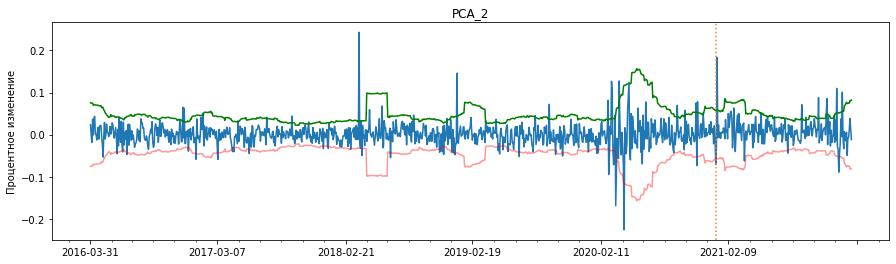

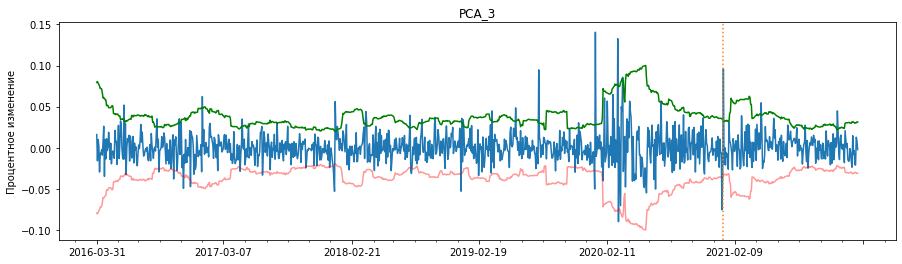

In [13]:
for i in range(df_pca.shape[1]):
    plt.figure(figsize=(15, 4))
    idx = all_df.index[window_size + t :]
    plt.plot(idx, df_pca[window_size + t :, i])
    plt.plot(idx, simulations[:, i], c="g")
    plt.plot(idx, -simulations[:, i], c="r", alpha=0.4)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())
    plt.axvline(split_date, c="tab:orange", linestyle=":")
    plt.title(f"PCA_{i+1}")
    plt.ylabel("Процентное изменение")
    plt.show()